# Basic usage of cucount, together with lsstypes
lsstypes is accessible at https://github.com/adematti/lsstypes

## Cutsky geometry

Let us first generate some fake data

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from cucount.numpy import count2, count2_analytic, Particles, BinAttrs, WeightAttrs, MeshAttrs, setup_logging
import lsstypes as types
from lsstypes import Count2, Count2Correlation

def generate_catalog(size=100, boxsize=(1000,) * 3, offset=(1000., 0., 0.), n_individual_weights=1, n_bitwise_weights=0, seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(0., 1., size) * b for o, b in zip(offset, boxsize)]
    weights = []
    weights += [rng.uniform(0.5, 1., size) for i in range(n_individual_weights)]
    # weights = utils.pack_bitarrays(*[rng.randint(0, 2, size) for i in range(64 * n_bitwise_weights)], dtype=np.uint64)
    # weights = utils.pack_bitarrays(*[rng.randint(0, 2, size) for i in range(33)], dtype=np.uint64)
    weights += [rng.randint(0, 0xffffffff, size, dtype=np.uint64) for i in range(n_bitwise_weights)]
    #weights += [np.full(size, 0xffffffff, dtype=np.uint64) for i in range(n_bitwise_weights)]
    return np.column_stack(positions), weights

boxsize = (3000.,) * 3

# Cutsky geometry
size = int(1e6)
data_positions, data_weights = generate_catalog(size, boxsize, n_individual_weights=1, seed=42)
randoms_positions, randoms_weights = generate_catalog(2 * size, boxsize=boxsize, n_individual_weights=1, seed=84)

Then compute the pair counts and Landy-Szalay estimator

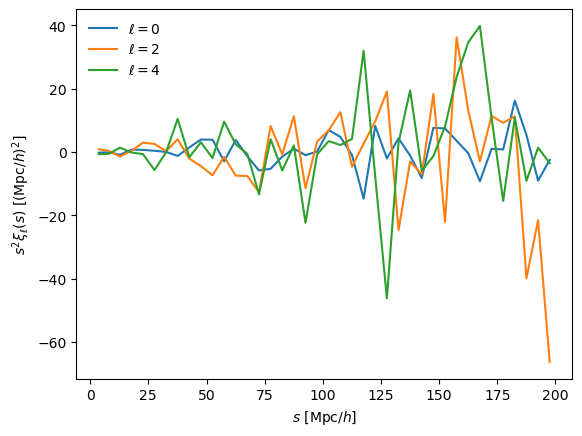

In [2]:
data = Particles(data_positions, data_weights)
randoms = Particles(randoms_positions, randoms_weights)

battrs = BinAttrs(s=np.linspace(0., 200., 201), mu=(np.linspace(-1., 1., 201), 'midpoint'))
wattrs = WeightAttrs()
# With bitwise weights, one would typically do:
# wattrs = WeightAttrs(bitwise=dict(weights=data.get('bitwise_weight'), p_correction_nbits=True))
mattrs = None

# Helper to convert to lsstypes Count2
def to_lsstypes(battrs: BinAttrs, counts: np.ndarray, norm: np.ndarray) -> Count2:
    coords = battrs.coords()
    edges = battrs.edges()
    edges = {f'{k}_edges': v for k, v in edges.items()}
    return Count2(counts=counts, norm=norm, **coords, **edges, coords=list(coords))

# Hepler to get counts as Count2
def get_counts(*particles: Particles, wattrs: WeightAttrs=None) -> Count2:
    if wattrs is None: wattrs = WeightAttrs()
    autocorr = len(particles) == 1
    counts = count2(*(particles * 2 if autocorr else particles), battrs=battrs, wattrs=wattrs, mattrs=mattrs)['weight']
    if autocorr:
        auto_sum = wattrs(*(particles * 2)).sum()
        norm = wattrs(particles[0]).sum()**2 - auto_sum
        # Correct auto-pairs
        zero_index = tuple(np.flatnonzero((0 >= edges[:, 0]) & (0 < edges[:, 1])) for edges in battrs.edges().values())
        counts[zero_index] -= auto_sum
    else:
        norm = wattrs(particles[0]).sum() * wattrs(particles[1]).sum()
    return to_lsstypes(battrs, counts, norm)

DD = get_counts(data, wattrs=wattrs)
DR = get_counts(data.clone(weights=wattrs(data)), randoms)  # clone data, with IIP weights (in case we provided bitwise weights)
RD = DR.clone(value=DR.value()[:, ::-1])  # reverse mu for RD
RR = get_counts(randoms)
# Note: you can also "sum" DR, RD and RR counts over multiple random catalogs to reduce noise
# DR = types.sum(list_of_DR_counts)
# RR = types.sum(list_of_RR_counts)

# For reconstructed 2PCF, you can provide DD, DS, SD, SS, RR counts
correlation = Count2Correlation(estimator='landyszalay', DD=DD, DR=DR, RD=RD, RR=RR)
dirname = Path('_tests')
fn = dirname / 'test_lsstypes_landyszalay.h5'
dirname.mkdir(exist_ok=True)
correlation.write(fn)

correlation = types.read(fn)
poles = correlation.select(s=slice(0, None, 5)).project(ells=[0, 2, 4])  # rebin and project
# You can write/read poles from disk
for ell in poles.ells:
    pole = poles.get(ell)
    pole.coords('s')  # coordinates
    pole.value()  # value
poles.plot(show=True);

## Periodic box geometry

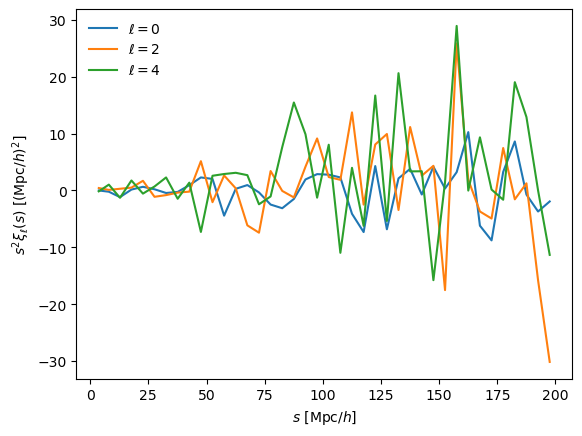

In [3]:
data_positions, data_weights = generate_catalog(int(1e6), boxsize, n_individual_weights=1, seed=42)
data = Particles(data_positions, data_weights)

battrs = BinAttrs(s=np.linspace(0., 200., 201), mu=(np.linspace(-1., 1., 201), 'x'))
wattrs = WeightAttrs()
mattrs = MeshAttrs(data, boxsize=boxsize, battrs=battrs, periodic=True)

DD = get_counts(data)
# In case of periodic geometry; analytic RR
RR = to_lsstypes(battrs, count2_analytic(battrs=battrs, mattrs=boxsize), norm=1.)
correlation = Count2Correlation(estimator='natural', DD=DD, RR=RR)
fn = dirname / 'test_lsstypes_natural.h5'
correlation.write(fn)
correlation = types.read(fn)
poles = correlation.select(s=slice(0, None, 5)).project(ells=[0, 2, 4])  # rebin and project
# You can write/read poles from disk
poles.plot(show=True);